In [1]:
import pandas as pd
import numpy as np

In [2]:
df1 = pd.read_csv('./data/credits.csv')
df2 = pd.read_csv('./data/keywords.csv')
df3 = pd.read_csv('./data/movies_metadata.csv')


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Demographic Filtering

In [3]:
print(df1.columns)
print(df2.columns)
print(df3.columns)
#print(df4.columns)

Index(['cast', 'crew', 'id'], dtype='object')
Index(['id', 'keywords'], dtype='object')
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [4]:
print(df1.shape, df2.shape, df3.shape)

(45476, 3) (46419, 2) (45466, 24)


(WR) = (v / (v+m)) × R + (m / (v+m)) × C 
v is the number of votes for the movie;
m is the minimum votes required to be listed in the chart;
R is the average rating of the movie; And
C is the mean vote across the whole report

In [5]:
C = df3.vote_average.mean()
print(C)

5.618207215134185


In [6]:
m = df3.vote_count.quantile(0.95)
print(m)

434.0


In [7]:
top_movies = df3.loc[df3['vote_count'] > m]
print(top_movies.shape)

(2268, 24)


In [8]:
def calculate_weighted_rating(movie, m=m, C=C):
    v = movie['vote_count']
    R = movie['vote_average']
    return (v / (v + m)) * R + (m / (v + m)) * C

In [9]:
top_movies['weighted_rating'] = top_movies.apply(calculate_weighted_rating, axis=1) 

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
top_movies = top_movies.sort_values('weighted_rating', ascending=False)

top_10_movies = top_movies.head(10)
print(top_10_movies[['id', 'title', 'weighted_rating']])

           id                     title  weighted_rating
314       278  The Shawshank Redemption         8.357746
834       238             The Godfather         8.306334
12481     155           The Dark Knight         8.208376
2843      550                Fight Club         8.184899
292       680              Pulp Fiction         8.172155
351        13              Forrest Gump         8.069421
522       424          Schindler's List         8.061007
23673  244786                  Whiplash         8.058025
5481      129             Spirited Away         8.035598
1154     1891   The Empire Strikes Back         8.025793


In [11]:
df3['popularity'] = df3['popularity'].replace(regex=r'[^0-9.]', value=0.0)
df3['popularity'] = df3['popularity'].astype(float)
most_popular = df3.sort_values('popularity', ascending=False)

print(most_popular[['id', 'title', 'popularity']].head(10))

           id                           title  popularity
30700  211672                         Minions  547.488298
33356  297762                    Wonder Woman  294.337037
42222  321612            Beauty and the Beast  287.253654
43644  339403                     Baby Driver  228.032744
24455  177572                      Big Hero 6  213.849907
26564  293660                        Deadpool  187.860492
26566  283995  Guardians of the Galaxy Vol. 2  185.330992
14551   19995                          Avatar  185.070892
24351  245891                       John Wick  183.870374
23675  210577                       Gone Girl  154.801009


## Content-Based Filtering

In [12]:
df3['overview'].head(10)

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
5    Obsessive master thief, Neil McCauley leads a ...
6    An ugly duckling having undergone a remarkable...
7    A mischievous young boy, Tom Sawyer, witnesses...
8    International action superstar Jean Claude Van...
9    James Bond must unmask the mysterious head of ...
Name: overview, dtype: object

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words = 'english')

df3['overview'] = df3['overview'].fillna('')
#df3.to_csv("movie_overview.csv")

matrix = tfidf.fit_transform(df3['overview'])

print(matrix.shape)

(45466, 75827)


In [14]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(matrix, matrix)

In [15]:
indices = pd.Series(df3.index, index=df3['title']).drop_duplicates()

In [16]:
index = indices['The Dark Knight']

print(cosine_sim[index])

[[0.         0.02185745 0.         ... 0.         0.         0.        ]
 [0.         0.04508723 0.         ... 0.         0.00270897 0.02284366]]


In [19]:
def get_recommendations(title, cosine_sim):
    index = indices[title]
    sim_scores = cosine_sim[index] if len(index.shape) == 0 else cosine_sim[index][0]
    sim_scores = list(enumerate(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #exclude first one
    sim_scores = sim_scores[1:11]
    
    movie_indices = [i[0] for i in sim_scores]
    
    return df3['title'].iloc[movie_indices]

In [24]:
get_recommendations('The Shawshank Redemption', cosine_sim)

16947                   They Made Me a Fugitive
6548                                Civil Brand
39141                         Seven Times Seven
11327                               Brute Force
36701                            Women's Prison
17446                           Girls in Prison
9391                                    In Hell
34185                   Women's Prison Massacre
9225     Female Prisoner Scorpion: Jailhouse 41
41606                           Alcatraz Island
Name: title, dtype: object

In [ ]:
#np.save('cosinesim.npy', cosine_sim, allow_pickle=True)

In [3]:
from ast import literal_eval

temp = df2.merge(df1,on='id')
df3 = df3[pd.to_numeric(df3['id'], errors='coerce').notnull()]
df3['id'] = df3['id'].astype(int)

df = df3.merge(temp, on='id')


In [4]:
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(literal_eval)

In [5]:
def get_director(crew):
    for i in crew:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [6]:
def get_list(feature):
    if isinstance(feature, list):
        names = [i['name'] for i in feature]
        
        #adjusted for memory available
        if len(names) > 1:
            return names[:1]
        
        return names
    
    return []

In [7]:
df['director'] = df['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']

for feature in features:
    df[feature] = df[feature].apply(get_list)

In [8]:
df[['title', 'cast', 'director', 'keywords', 'genres']].head(2)

,title,cast,director,keywords,genres
0,Toy Story,[Tom Hanks],John Lasseter,[jealousy],[Animation]
1,Jumanji,[Robin Williams],Joe Johnston,[board game],[Adventure]


In [9]:
import re
def clean_data(x):
    if isinstance(x, list):
        return [re.sub("\s+", "", s.lower()) for s in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ""

In [10]:
for feature in ['cast', 'keywords', 'director', 'genres']:
    df[feature] = df[feature].apply(clean_data)

In [11]:
df[['title', 'cast', 'director', 'keywords', 'genres']].head(2)

,title,cast,director,keywords,genres
0,Toy Story,[tomhanks],johnlasseter,[jealousy],[animation]
1,Jumanji,[robinwilliams],joejohnston,[boardgame],[adventure]


In [12]:
def combine_data(movie):
    
    result = [" ".join(movie[feature]) for feature in ['cast', 'genres']]
    result.append(movie['director'])
    return " ".join(result)
    

df['all_data'] = df.apply( combine_data , axis=1)

In [13]:
df['all_data'].head()

0         tomhanks animation johnlasseter
1     robinwilliams adventure joejohnston
2      waltermatthau romance howarddeutch
3    whitneyhouston comedy forestwhitaker
4         stevemartin comedy charlesshyer
Name: all_data, dtype: object

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')

count_matrix = count.fit_transform(df['all_data'])

In [15]:
print(count_matrix.shape)

(46628, 35549)


In [16]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [17]:
df = df.reset_index()
indices = pd.Series(df.index, index=df['title'])
#make reccomendations
def get_recommendations(title, cosine_sim):
    index = indices[title]
    sim_scores = cosine_sim[index] if len(index.shape) == 0 else cosine_sim[index][0]
    sim_scores = list(enumerate(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #exclude first one
    sim_scores = sim_scores[1:11]
    
    movie_indices = [i[0] for i in sim_scores]
    
    return df['title'].iloc[movie_indices]

In [18]:
get_recommendations('The Dark Knight', cosine_sim2)

1995                                               Newsies
4004                                     Empire of the Sun
10210                                        Batman Begins
11463                                         The Prestige
18442                                The Dark Knight Rises
18649                                   The Flowers of War
1648                                      Ill Gotten Gains
3487                            Jails, Hospitals & Hip-Hop
3790     Went to Coney Island on a Mission from God... ...
5948                                   Divine Intervention
Name: title, dtype: object

In [ ]:
#np.save('cosinesim2.npy', cosine_sim2, allow_pickle=True)

In [ ]:
#df.to_csv("movie_content_data.csv")

## Collaborative Filtering

In [12]:
#lack of memory cannot use
#df4 = pd.read_csv('./data/ratings.csv')
df4 = pd.read_csv('./data/ratings_small.csv')

df3 = df3[pd.to_numeric(df3['id'], errors='coerce').notnull()]
movie_names['movieId'] = df3.rename(columns={"id": "movieId"})['movieId'].astype(int) 

df4['movieId'] = df4['movieId'].astype(int)
movie_data = pd.merge(df4, movie_names, on='movieId')

In [13]:
movie_data.shape

(44994, 27)

In [14]:
movie_data.head()
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Frank Herbert's Dune    5.0
Long Pigs               5.0
The Brothers Grimm      5.0
Knight Moves            5.0
Kismet                  5.0
Name: rating, dtype: float64

In [15]:
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())

In [16]:
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())

In [17]:
ratings_mean_count.head()

,rating,rating_counts
title,,
!Women Art Revolution,3.25,2
'Gator Bait,0.50,1
'Twas the Night Before Christmas,4.00,2
...And God Created Woman,4.00,1
00 Schneider - Jagd auf Nihil Baxter,4.00,2


In [18]:
ratings_mean_count.sort_values('rating_counts', ascending=False).head(10)


,rating,rating_counts
title,,
Terminator 3: Rise of the Machines,4.256173,324
The Million Dollar Hotel,4.487138,311
Solaris,4.134426,305
The 39 Steps,4.221649,291
Monsoon Wedding,3.706204,274
Once Were Warriors,4.303279,244
Three Colors: Red,3.945175,228
Men in Black II,4.256696,224
The Passion of Joan of Arc,3.483945,218


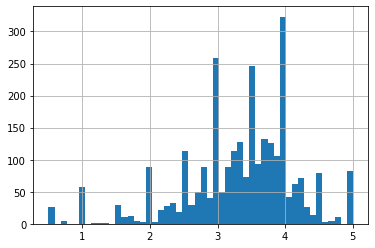

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
ratings_mean_count['rating'].hist(bins=50)

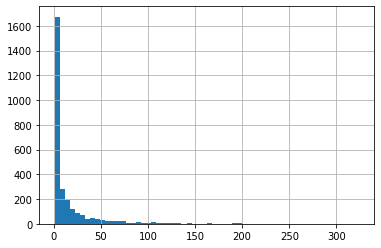

In [21]:
ratings_mean_count['rating_counts'].hist(bins=60)

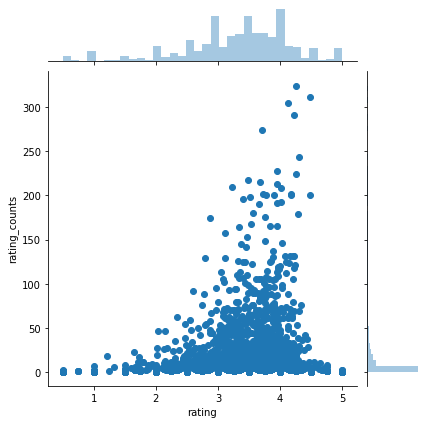

In [22]:
import seaborn as sns
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count)

In [23]:
user_movie_rating = movie_data.pivot_table(index='userId', columns='title', values='rating')

In [24]:
user_movie_rating.head()

title,!Women Art Revolution,'Gator Bait,'Twas the Night Before Christmas,...And God Created Woman,00 Schneider - Jagd auf Nihil Baxter,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,...,Zodiac,Zombie Flesh Eaters,Zombie Holocaust,Zozo,eXistenZ,xXx,¡Three Amigos!,À nos amours,Ödipussi,Şaban Oğlu Şaban
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
def get_recommendation(title):
    user_rating = user_movie_rating[title]
    similar_to = user_movie_rating.corrwith(user_rating)
    corr = pd.DataFrame(similar_to, columns=['correlation'])
    corr.dropna(inplace=True)
    corr = corr.join(ratings_mean_count['rating_counts'])
    
    most_similar = corr[corr['rating_counts'] > 100].sort_values(by='correlation', ascending=False)
    
    return most_similar
    

In [34]:
get_recommendation("The Dark Knight").head(10)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,correlation,rating_counts
title,,
Monsieur Hulot's Holiday,1.000000,124
The Bourne Supremacy,1.000000,106
Who Killed Bambi?,1.000000,113
5 Card Stud,1.000000,200
My Name Is Bruce,1.000000,119
The Cave of the Yellow Dog,0.997176,106
Judgment Night,0.886619,104
Beauty and the Beast,0.826811,168
The Passion of Joan of Arc,0.779325,218
